In [194]:
import diplib as dip
import matplotlib
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import string
from tqdm import trange
import seaborn as sns
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

matplotlib.rcParams['font.family'] = 'STIXGeneral'
image_dir = 'images/'

# 5.1

In [39]:
def min_max_rescale(img):
    # rescale to 0..1
    return (img - np.min(img)) / (np.max(img) - np.min(img)) 


def segment_embryo(img):
    img_np = np.array(img)
    grayscale = 0.3 * img_np[:, :, 0] + 0.59 * img_np[:, :, 1] + 0.11 * img_np[:, :, 2]
    grayscale = dip.Image(grayscale)
    smoothed = dip.Gauss(grayscale, sigmas=[2.0])
    thresholded = dip.TriangleThreshold (smoothed)
    labeled = dip.Label(thresholded, connectivity=2)
    sizes = dip.MeasurementTool.Measure(labeled, features=['Size'])
    largest_label = np.argmax(sizes['Size']) + 1
    mask = labeled == largest_label
    
    return mask

def unify_images(images):
    unified_images = {}
    for key in images.keys():
        parsed_img = np.mean(images[key], axis=0)
        unified_images[key] = dip.Image(parsed_img)
    return unified_images


def convert_to_datastructure(images):
    output = []
    for img_name in images.keys():
        output.append((images[img_name], f'w8t1t2_d7_{img_name}.tif'))
    return output


def load_images(image_dir):
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    obj_pattern = r'(\d{2}).*\.tif'
    raw_images = {}
    
    for image_file in image_files:
        if 'flipped' in image_file: # discard this image
            continue
        object_name = re.search(obj_pattern, image_file).group(1)
        if object_name not in raw_images.keys():
            raw_images[object_name] = []
        img = dip.ImageReadTIFF(os.path.join(image_dir, image_file))
        img = min_max_rescale(img)
        raw_images[object_name].append(img)
    
    unified_images = unify_images(raw_images)
    return unified_images
        

def process_images(images):
    processed_images = {}
    for img_name in images.keys():
        mask = segment_embryo(images[img_name])
        processed_images[img_name] = mask
    return processed_images


def create_image_panel(images, suptitle):
    fig, axes = plt.subplots(4, 15, figsize=(28, 8))
    axes = axes.flatten()
    img_names = sorted(list(images.keys()))
    for ax, img_name in zip(axes, img_names):
        ax.imshow(images[img_name], cmap='gray')
        ax.set_title(f'w8t1t2_d7_{img_name}.tif')
    [ax.axis('off') for ax in axes]
    plt.suptitle(suptitle, fontsize=18, y=0.98)
    plt.tight_layout()
    plt.savefig(f'figures/{suptitle.lower().replace(' ', '_')}.png')


def label_images(segmented_images):
    labeled_images = {}
    for img_name in segmented_images.keys():
        labeled_images[img_name] = dip.Label(segmented_images[img_name],
                                             connectivity=2)
    return labeled_images


In [40]:
# Load and process data
images_all = {'raw': {}, 'segmented': {}}
images_all['raw'] = load_images(image_dir)
images_all['segmented'] = process_images(images_all['raw'])
images_all['labeled'] = label_images(images_all['segmented'])

In [41]:
create_image_panel(images_all['raw'], 'Original Images')
create_image_panel(images_all['segmented'], 'Segmented Images')

# 5.2

In [8]:
def measure_features(img, mask, labeled):
    area = np.sum(mask)
    measurements = dip.MeasurementTool.Measure(labeled,
                                               features=['Perimeter', 'Size',
                                                         'Feret', 'Roundness'])
    # shape_features = measurements[labeled==1]  # Assuming single labeled object
    largest_label = np.argmax(measurements['Size']) + 1

    # print (measurements['Perimeter'][largest_label])
    # print(measurements)
    # print(img.TensorElement(0))
    
    # convert to HSV, then use saturation channel to find the blue
    hsv_img = dip.ColorSpaceManager.Convert(img, 'HSV')
    saturation_channel = hsv_img.TensorElement(1)
    
    # mask the saturation channel again, so most of the embryo is excluded
    blue_threshold = 0.7 
    blue_mask = saturation_channel > blue_threshold
    
    # use both blue mask and regular mask to only measure blue size
    absolute_blue = np.sum(saturation_channel[blue_mask & mask])
    relative_blue = absolute_blue / area
    
    # print(relative_blue)
    
    # fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # axes[0].imshow(np.array(img), cmap='gray')
    # axes[0].set_title('original')
    # axes[0].axis('off')
    
    # axes[1].imshow(np.array(blue_mask), cmap='gray')
    # axes[1].set_title('blue_mask')
    # axes[1].axis('off')
    
    # # Apply mask to saturation channel
    # masked_saturation = np.array(saturation_channel) * mask
    # axes[2].imshow(masked_saturation, cmap='gray')
    # axes[2].set_title('masked saturation')
    # axes[2].axis('off')
    
    # plt.tight_layout()
    # plt.show()

    return {
        'Area': area,
        'Perimeter': measurements['Perimeter'][largest_label][0],
        # 'Feret': measurements['Feret'][largest_label],
        'Roundness': measurements['Roundness'][largest_label][0],
        'absolute_blue': absolute_blue,
        'relative_blue': relative_blue
    }

def process_images(raw_images, segmented_images, labeled_images):
    all_features = []
    
    for img_name in raw_images.keys():
        features = measure_features(raw_images[img_name],
                                    segmented_images[img_name],
                                    labeled_images[img_name])
        features['Image'] = f'w8t1t2_d7_{img_name}.tif'
        all_features.append(features)
        # break
    
    return all_features


image_dir = 'images/'
all_features = process_images(images_all['raw'],
                              images_all['segmented'],
                              images_all['labeled'])
features_df = pd.DataFrame(all_features)


/var/folders/j8/xlfl488j7csblljxvg0xx4nh0000gn/T/ipykernel_37358/3159806519.py:15: DeprecationWarning: dip.Image.TensorElement() is deprecated and will be removed in a future version of PyDIP. Use () indexing instead.
  saturation_channel = hsv_img.TensorElement(1)


In [16]:
features_df.sort_values(by='Image').head()

,Area,Perimeter,Roundness,absolute_blue,relative_blue,Image,RelativeBlue,Cluster
25,219893,4843.584593,0.119866,51657.175781,0.234920,w8t1t2_d7_01.tif,0.234920,2
20,246088,3693.971593,0.227417,53491.968750,0.217369,w8t1t2_d7_02.tif,0.217369,2
21,212139,3048.414593,0.287421,102108.359375,0.481328,w8t1t2_d7_03.tif,0.481328,0
8,351637,5010.900593,0.178896,19406.957031,0.055190,w8t1t2_d7_04.tif,0.055190,2
12,230210,3023.645593,0.316480,35179.796875,0.152816,w8t1t2_d7_05.tif,0.152816,1


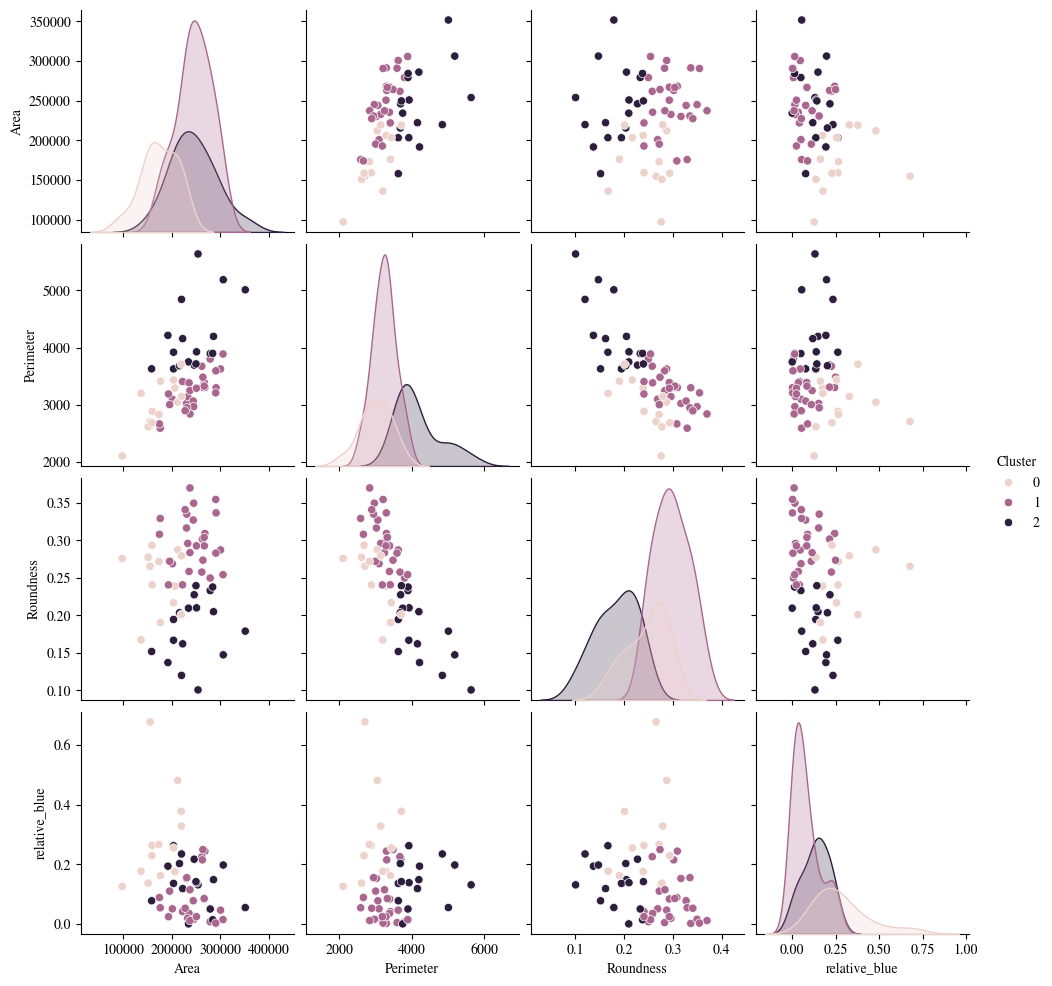

                  Area    Perimeter  Roundness  relative_blue
Cluster                                                      
1        245788.357143  3238.162021   0.297605       0.079113
2        244541.941176  4175.800710   0.183765       0.136685
0        174461.230769  3006.049285   0.246594       0.281429


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
# kmeans to find three groups in the images



# features = features_df[['Area', 'Perimeter', 'Feret', 'Roundness', 'relative_blue']]
features = features_df[['Area', 'Perimeter', 'Roundness', 'relative_blue']]

# features['Feret'] = features['Feret'].apply(lambda x: x[0])
features_df['Perimeter'] = pd.to_numeric(features_df['Perimeter'])
# features_df['Feret'] = pd.to_numeric(features_df['Feret'])
features_df['Roundness'] = pd.to_numeric(features_df['Roundness'])
features_df['RelativeBlue'] = pd.to_numeric(features_df['relative_blue'])


scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
features_df['Cluster'] = kmeans.fit_predict(scaled_features)

features_df['Cluster'] = kmeans.labels_

# df = features_df[['Area', 'Perimeter', 'Feret', 'Roundness', 'relative_blue', 'Cluster']]
df = features_df[['Area', 'Perimeter', 'Roundness', 'relative_blue', 'Cluster']]
# sns.pairplot(df, hue='Cluster', diag_kind='kde', vars=['Area', 'Perimeter', 'Feret', 'Roundness', 'relative_blue'])
sns.pairplot(df, hue='Cluster', diag_kind='kde', vars=['Area', 'Perimeter', 'Roundness', 'relative_blue'])
plt.show()

cluster_summary = df.groupby('Cluster').mean()
cluster_summary = cluster_summary.sort_values(by='relative_blue', ascending=True)
print(cluster_summary)

In [12]:
thresholds = {}
for cluster in range(3):  
    cluster_data = features_df[features_df['Cluster'] == cluster]
    thresholds[cluster] = {}
    # for column in ['Area', 'Perimeter', 'Feret', 'Roundness', 'RelativeBlue']:
    for column in ['Area', 'Perimeter', 'Roundness', 'RelativeBlue']:

        thresholds[cluster][column] = {
            'min': cluster_data[column].min(),
            'max': cluster_data[column].max()
        }
        print(f"Cluster {cluster} - {column} min: {thresholds[cluster][column]['min']}, max: {thresholds[cluster][column]['max']}")


Cluster 0 - Area min: 97357, max: 219557
Cluster 0 - Perimeter min: 2106.1515926535894, max: 3710.205592653589
Cluster 0 - Roundness min: 0.16724033007184902, max: 0.2935417261961656
Cluster 0 - RelativeBlue min: 0.1263893474050402, max: 0.677806736304265
Cluster 1 - Area min: 174242, max: 305692
Cluster 1 - Perimeter min: 2591.3725926535894, max: 3888.0865926535894
Cluster 1 - Roundness min: 0.24058616723642426, max: 0.3699095694831653
Cluster 1 - RelativeBlue min: 0.0019482278347147935, max: 0.24958853709124093
Cluster 2 - Area min: 158130, max: 351637
Cluster 2 - Perimeter min: 3628.0615926535893, max: 5637.71359265359
Cluster 2 - Roundness min: 0.10052127185400413, max: 0.23953423592570966
Cluster 2 - RelativeBlue min: 0.0004646528264302224, max: 0.26263913491882085


# 5.3

## Texture Features

In [56]:
def split_into_channels(raw_img, segmented_img):
    img = dip.Copy(raw_img)
    blue_channel = dip.Image(np.array(img)[:, :, 2])
    other_channels = dip.Image(np.array(img)[:, :, :2])
    blue_channel[~segmented_img] = 0
    other_channels[~segmented_img] = 0
    return blue_channel, other_channels

def uniformity(img):
    # rescale to 0..255
    img = 255 * min_max_rescale(img)
    img = np.array(img).astype(int)
    size = np.prod(img.shape)
    _, counts = np.unique(img, return_counts=True)
    counts = counts / size
    return (counts ** 2).sum()

def standard_deviation(labeled_img, img):
    msr = dip.MeasurementTool.Measure(labeled_img, img,
                                      features=['StandardDeviation'])
    if msr.NumberOfObjects() > 1:
        print('Oopsie')
    return msr['StandardDeviation'][1][0]

In [218]:
uniforimities = []
uniforimities_blue = []
stdevs = []
stdevs_blue = []
for img_name in images_all['raw'].keys():
    blue_channel, other_channels = split_into_channels(
        images_all['raw'][img_name], images_all['segmented'][img_name]
    )
    uniforimities_blue.append(uniformity(blue_channel))
    uniforimities.append(uniformity(other_channels))
    stdevs.append(standard_deviation(
        images_all['labeled'][img_name], other_channels))
    stdevs_blue.append(standard_deviation(
        images_all['labeled'][img_name], blue_channel))
    
texture_features = pd.DataFrame(data={'uniformity_blue': uniforimities_blue,
                                      'uniforimity_other': uniforimities,
                                      'stdev_blue':  stdevs_blue,
                                      'stdev_other':  stdevs})

texture_features = pd.merge(features_df[['Cluster']], texture_features,
                            left_index=True, right_index=True)

In [58]:
fig, ax = plt.subplots()
sns.kdeplot(uniforimities_blue, ax=ax, label='Blue channel',
            color='#4866fa', fill=True)
sns.kdeplot(uniforimities, ax=ax, label='Other channels',
            color='grey', fill=True)
sns.despine()
ax.grid(axis='y')
ax.set_xlim(xmin=0, xmax=1)
ax.legend(loc='upper left')
ax.set_title('Uniformity distribution for the blue channel vs other channels.')
plt.savefig('figures/uniformity_histogram.png')

In [61]:
fig, ax = plt.subplots()
sns.kdeplot(stdevs_blue, ax=ax, label='Blue channel',
            color='#4866fa', fill=True)
sns.kdeplot(stdevs, ax=ax, label='Other channels',
            color='grey', fill=True)
sns.despine()
ax.grid(axis='y')
ax.legend(loc='upper right')
ax.set_title('Standard deviation distribution of intensity\n'
             'for the blue channel vs other channels.')
plt.savefig('figures/stdev_histogram.png')

## HOG features

In [109]:
hogs = {img_num: {
    'hog16_blue': {}, 'hog16_other': {},
    'hog64_blue': {}, 'hog64_other': {}}
    for img_num in images_all['raw'].keys()}

for img_num in images_all['raw'].keys():
    blue_channel, other_channels = split_into_channels(
        images_all['raw'][img_name], images_all['segmented'][img_name]
    )
    for px_num in (16, 64):
        hm_blue = hog(blue_channel, orientations=8,
                      pixels_per_cell=(px_num, px_num),
                      cells_per_block=(1, 1))
        hm_other = hog(other_channels, orientations=8,
                       pixels_per_cell=(px_num, px_num),
                       cells_per_block=(1, 1), channel_axis=2)
        hogs[img_num][f'hog{px_num}_blue'] = hm_blue
        hogs[img_num][f'hog{px_num}_other'] = hm_other

hogs_joined = {img_num: np.concatenate(
    [hogs[img_num][i] for i in hogs[img_num].keys()]
    ) for img_num in hogs.keys()}
hogs_features = pd.DataFrame(hogs_joined).T.sort_index()
hogs_features = hogs_features.reset_index().rename({'index': 'Image'}, axis=1)
hogs_features['Image'] = hogs_features.Image.apply(
    lambda x: f'w8t1t2_d7_{x}.tif')
hogs_features = hogs_features.merge(features_df[['Image', 'Cluster']], 
                                    on='Image')

# 5.4

In [209]:
def prepare_dataset(df, target_name):
    X = df.drop(columns=[target_name])
    y = df[target_name].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        shuffle=True,
                                                        random_state=42)
    return X_train, X_test, y_train, y_test


def train_svm(X_train, y_train):
    svm = SVC(kernel='linear', random_state=42)
    svm.fit(X_train, y_train)
    return svm


def evaluate_svm(svm, X_test, y_test):
    y_pred = svm.predict(X_test)
    report = classification_report(y_test, y_pred, zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred)
    return report, conf_matrix


def svm_pipeline(df, target_name):
    X_train, X_test, y_train, y_test = prepare_dataset(df, target_name)
    svm = train_svm(X_train, y_train)
    report, conf_matrix = evaluate_svm(svm, X_test, y_test)
    return report, conf_matrix

In [272]:
texture_report, texture_cmat = svm_pipeline(texture_features, 'Cluster')

shape_report, shape_cmat = svm_pipeline(
    features_df.drop(columns='Image'), 'Cluster')

hog_report, hog_cmat = svm_pipeline(
    hogs_features.drop(columns='Image'), 'Cluster')

In [273]:
all_df = pd.merge(texture_features, features_df.drop(columns=['Cluster', 'Image']),
                  left_index=True, right_index=True)
all_df = pd.merge(all_df, hogs_features.drop(columns=['Cluster', 'Image']),
                  left_index=True, right_index=True)
all_df.columns = [str(col) for col in all_df.columns]

all_report, all_cmat = svm_pipeline(all_df, 'Cluster')


In [274]:
print(shape_report)

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00         2

    accuracy                           0.92        12
   macro avg       0.96      0.89      0.91        12
weighted avg       0.93      0.92      0.91        12



# testing with tensorelements

C:\Users\bramv\AppData\Local\Temp\ipykernel_23776\1311614499.py:6: DeprecationWarning: dip.Image.TensorElement() is deprecated and will be removed in a future version of PyDIP. Use () indexing instead.
  red_channel = img.TensorElement(0)
C:\Users\bramv\AppData\Local\Temp\ipykernel_23776\1311614499.py:7: DeprecationWarning: dip.Image.TensorElement() is deprecated and will be removed in a future version of PyDIP. Use () indexing instead.
  green_channel = img.TensorElement(1)
C:\Users\bramv\AppData\Local\Temp\ipykernel_23776\1311614499.py:8: DeprecationWarning: dip.Image.TensorElement() is deprecated and will be removed in a future version of PyDIP. Use () indexing instead.
  blue_channel = img.TensorElement(2)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


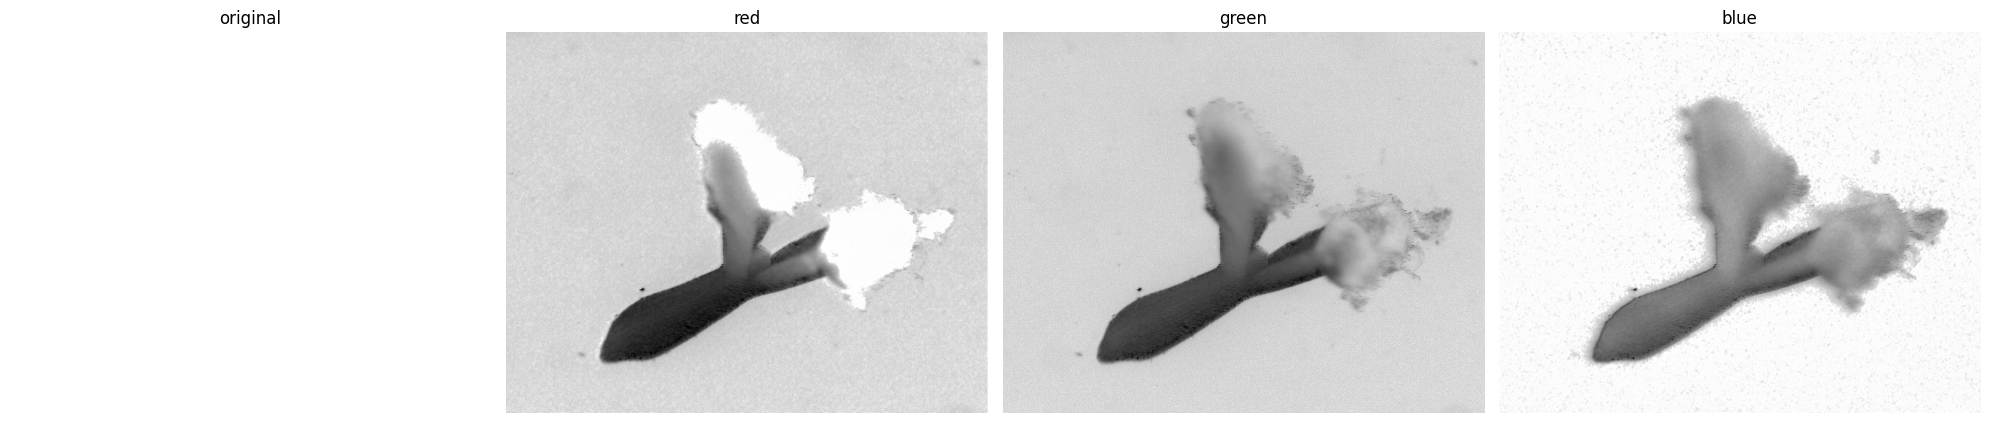

In [ ]:
def plot_image_channels(image_path):
    img = dip.ImageReadTIFF(image_path)
    img = img / 2 ** 16
    img = dip.ColorSpaceManager.Convert(img, 'CMY')

    red_channel = img.TensorElement(0)
    green_channel = img.TensorElement(1)
    blue_channel = img.TensorElement(2)
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    axes[0].imshow(np.array(img), cmap='gray')
    axes[0].set_title('original')
    axes[0].axis('off')
    
    axes[1].imshow(np.array(red_channel), cmap='gray')
    axes[1].set_title('red')
    axes[1].axis('off')
    
    axes[2].imshow(np.array(green_channel), cmap='gray')
    axes[2].set_title('green')
    axes[2].axis('off')
    
    axes[3].imshow(np.array(blue_channel), cmap='gray')
    axes[3].set_title('blue')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()

image_path = 'images/w8t1t2_d7_01.tif'
plot_image_channels(image_path)


C:\Users\bramv\AppData\Local\Temp\ipykernel_23776\2785859745.py:7: DeprecationWarning: dip.Image.TensorElement() is deprecated and will be removed in a future version of PyDIP. Use () indexing instead.
  hue_channel = hsv_img.TensorElement(0)
C:\Users\bramv\AppData\Local\Temp\ipykernel_23776\2785859745.py:8: DeprecationWarning: dip.Image.TensorElement() is deprecated and will be removed in a future version of PyDIP. Use () indexing instead.
  saturation_channel = hsv_img.TensorElement(1)
C:\Users\bramv\AppData\Local\Temp\ipykernel_23776\2785859745.py:9: DeprecationWarning: dip.Image.TensorElement() is deprecated and will be removed in a future version of PyDIP. Use () indexing instead.
  value_channel = hsv_img.TensorElement(2)


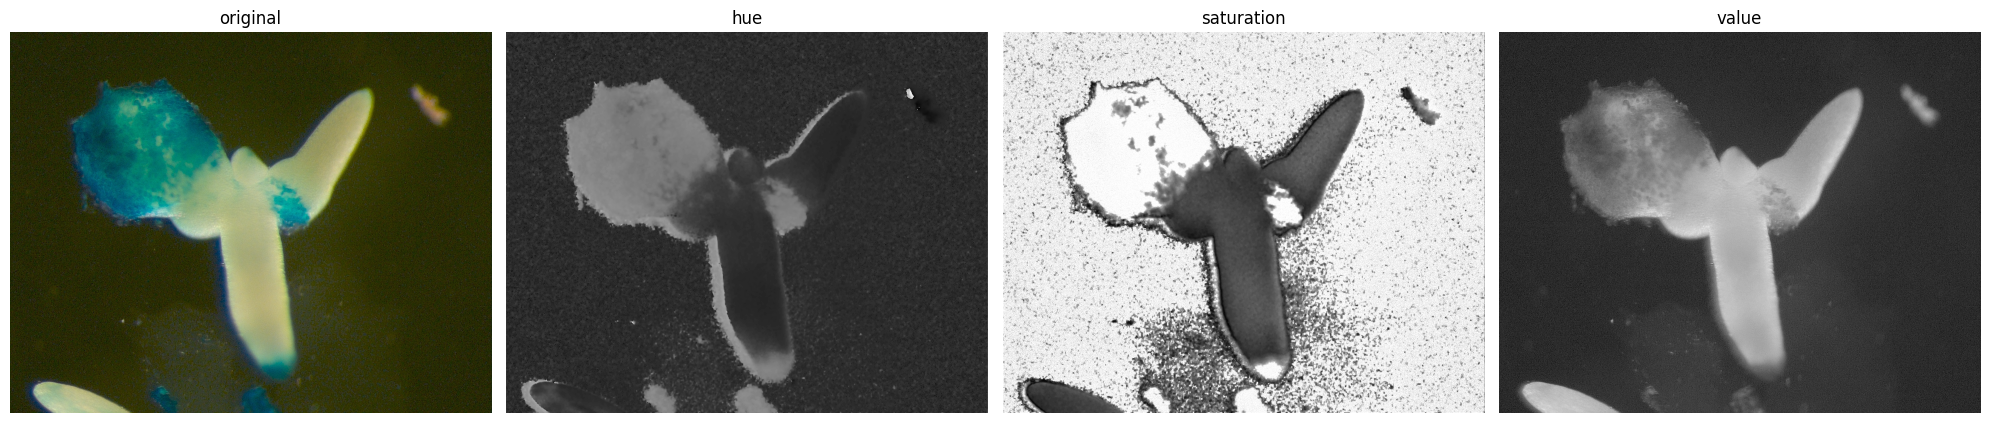

In [ ]:
def plot_image_hsv_channels(image_path):
    img = dip.ImageReadTIFF(image_path)
    img = img / 2 ** 16

    hsv_img = dip.ColorSpaceManager.Convert(img, 'HSV')
    
    hue_channel = hsv_img.TensorElement(0)
    saturation_channel = hsv_img.TensorElement(1)
    value_channel = hsv_img.TensorElement(2)
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    axes[0].imshow(np.array(img), cmap='gray')
    axes[0].set_title('original')
    axes[0].axis('off')
    
    axes[1].imshow(np.array(hue_channel), cmap='gray')
    axes[1].set_title('hue')
    axes[1].axis('off')
    
    axes[2].imshow(np.array(saturation_channel), cmap='gray')
    axes[2].set_title('saturation')
    axes[2].axis('off')
    
    axes[3].imshow(np.array(value_channel), cmap='gray')
    axes[3].set_title('value')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()

image_path = 'images/w8t1t2_d7_02.tif'
plot_image_hsv_channels(image_path)
